In [1]:
#!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt

In [3]:
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']
stock_data = yf.download(symbols_list, start="2000-01-01")
prices = stock_data["Adj Close"]
print(prices.shape)
prices.head()

[*********************100%***********************]  10 of 10 completed
(5191, 10)


,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
1999-12-31,3.173011,76.1250,12.651278,35.990559,12.303241,NaN,3.156762,NaN,NaN,47.894314
2000-01-03,3.454628,89.3750,11.687977,34.042202,11.907217,NaN,3.100056,NaN,NaN,51.060867
2000-01-04,3.163368,81.9375,11.174217,32.756821,11.920419,NaN,3.204020,NaN,NaN,48.685936
2000-01-05,3.209661,69.7500,11.495318,32.040653,12.026028,NaN,3.478111,NaN,NaN,51.192802
2000-01-06,2.931901,65.5625,12.587049,32.693417,12.039227,NaN,3.383597,NaN,NaN,50.137272


In [4]:
market_prices = yf.download("SPY", start="2000-01-01")["Adj Close"]
print(market_prices.shape)
market_prices.tail()

[*********************100%***********************]  1 of 1 completed
(5190,)


Date
2020-08-11    332.799988
2020-08-12    337.440002
2020-08-13    336.829987
2020-08-14    336.839996
2020-08-17    337.910004
Name: Adj Close, dtype: float64

In [5]:
mkt_caps = {}
for symbol in symbols_list:
    stock = yf.Ticker(symbol)
    print(stock.info["marketCap"])
    mkt_caps[symbol] = stock.info["marketCap"]

mkt_caps

1960077033472
78543462400
4501199360
5788334080
25826981888
212723597312
3857683712
1594037239808
207083159552
342093529088


{'AAPL': 1960077033472,
 'AXP': 78543462400,
 'UAA': 4501199360,
 'APA': 5788334080,
 'SU': 25826981888,
 'NFLX': 212723597312,
 'XRX': 3857683712,
 'AMZN': 1594037239808,
 'KO': 207083159552,
 'TSLA': 342093529088}

# Constructing the prior

In [6]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.4859946910327888

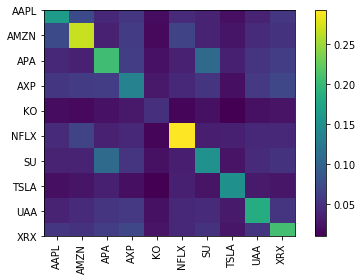

In [7]:
plotting.plot_covariance(S);

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mkt_caps, delta, S)
market_prior

AAPL    0.177040
AMZN    0.223079
APA     0.077383
AXP     0.099261
KO      0.048164
NFLX    0.112331
SU      0.074309
TSLA    0.069518
UAA     0.077587
XRX     0.093631
dtype: float64

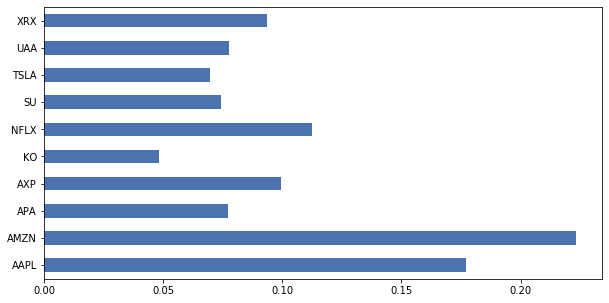

In [9]:
market_prior.plot.barh(figsize=(10,5));

# Personal investment views

In [10]:
# You don't have to provide views on all the assets
viewdict = {
    "AAPL": 0.10, # I think Apple will go up 10%
    "APA": 0.25,
    "AXP": 0.05,
    "XRX": 0.05,
    "AMZN": 0.30, 
    "NFLX": 0.30,
    "UAA": 0.15,
    "SU": 0.10,
    "KO": 0.10,
    "TSLA": 0.30
}

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.05, 0.20),
    (-0.05, 0.10),
    (0.20, 0.35),
    (0.20, 0.45),
    (0.00, 0.2),
    (0.08, 0.12),
    (0.1, 0.2),
    (0.10, 0.50)
]


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

bl = BlackLittermanModel(S, pi="market", market_caps=mkt_caps, risk_averison="delta", absolute_views=viewdict, omega=omega)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.005624999999999997, 0.015625, 0.010000000000000002, 0.00039999999999999986, 0.0025000000000000005, 0.04000000000000001]


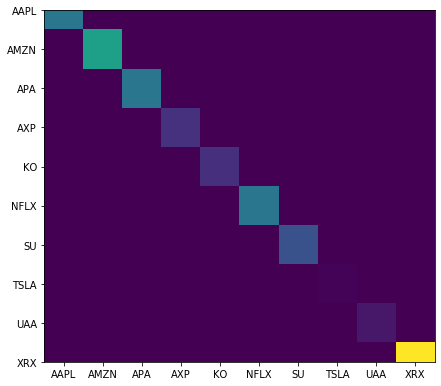

In [11]:
# Shows investor's forward view
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

# Estimate posterior returns

In [12]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.139655
AMZN    0.235584
APA     0.131291
AXP     0.097365
KO      0.063948
NFLX    0.198299
SU      0.099833
TSLA    0.135380
UAA     0.120099
XRX     0.077692
dtype: float64

In [13]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.177040,0.139655,0.10
AMZN,0.223079,0.235584,0.30
APA,0.077383,0.131291,0.25
AXP,0.099261,0.097365,0.05
KO,0.048164,0.063948,0.10
NFLX,0.112331,0.198299,0.30
SU,0.074309,0.099833,0.10
TSLA,0.069518,0.135380,0.30
UAA,0.077587,0.120099,0.15
XRX,0.093631,0.077692,0.05


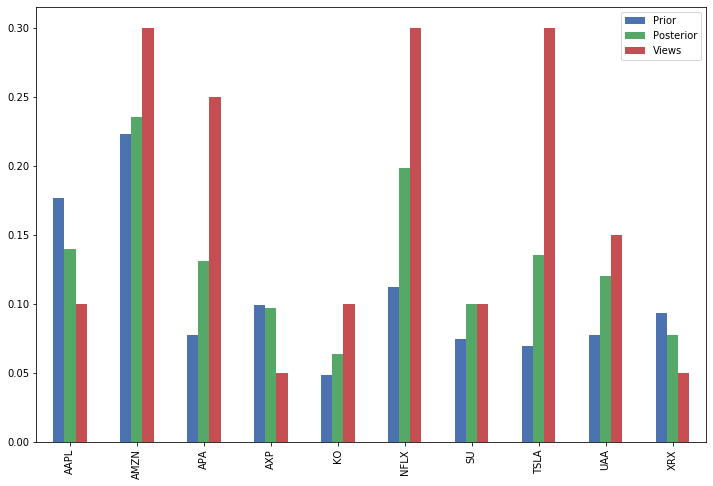

In [14]:
rets_df.plot.bar(figsize=(12,8));

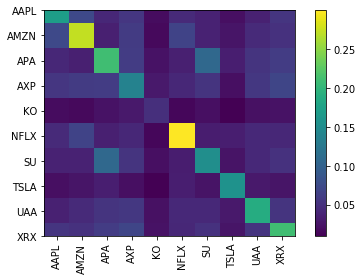

In [15]:
# Estimate of covariance matrix, factoring investor views
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [16]:
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(0,0.25))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_constraint(lambda x : x >= 0.025)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\Marcus\Anaconda3\lib\site-packages\pypfopt\efficient_frontier.py:182: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


OrderedDict([('AAPL', 0.10839),
             ('AMZN', 0.24573),
             ('APA', 0.09301),
             ('AXP', 0.025),
             ('KO', 0.06168),
             ('NFLX', 0.16769),
             ('SU', 0.025),
             ('TSLA', 0.17558),
             ('UAA', 0.07292),
             ('XRX', 0.025)])

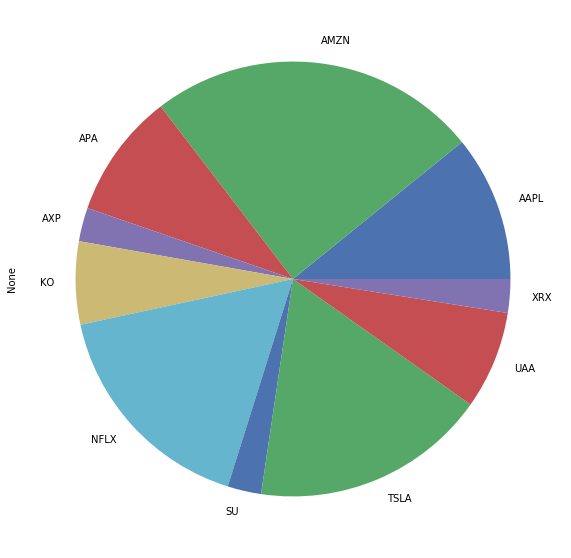

In [17]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [18]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $8.51


{'AAPL': 23.0,
 'AMZN': 8.0,
 'APA': 589.0,
 'AXP': 23.0,
 'KO': 122.0,
 'NFLX': 34.0,
 'SU': 147.0,
 'TSLA': 10.0,
 'UAA': 676.0,
 'XRX': 138.0}

In [19]:
print("Black-Litterman Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef.portfolio_performance()))

Black-Litterman Portfolio Analysis:
	Expected annual return: 0.161836
	Annual Volatility: 0.262475
	Sharpe ratio: 0.540379


# Allow shorting

In [20]:
ef_with_short = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef_with_short.add_objective(objective_functions.L2_reg, gamma=0.1)
ef_with_short.max_sharpe()
weights_with_short = ef_with_short.clean_weights()
weights_with_short

OrderedDict([('AAPL', 0.12217),
             ('AMZN', 0.25691),
             ('APA', 0.10447),
             ('AXP', 0.00299),
             ('KO', 0.07456),
             ('NFLX', 0.17511),
             ('SU', 0.03464),
             ('TSLA', 0.18332),
             ('UAA', 0.08476),
             ('XRX', -0.03893)])

In [21]:
print("Black-Litterman with shorts Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef_with_short.portfolio_performance()))

Black-Litterman with shorts Portfolio Analysis:
	Expected annual return: 0.166515
	Annual Volatility: 0.266553
	Sharpe ratio: 0.549668
